# Modified LeNet for AI-Generated Image Detection

This notebook implements a modified LeNet architecture specifically designed to detect AI-generated images. The classic LeNet-5 architecture will be significantly enhanced with modern CNN techniques to improve its ability to detect synthetic images.

## 1. Import Required Libraries

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageChops, ImageEnhance
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
from tqdm.notebook import tqdm

# New imports for Hugging Face datasets
from datasets import load_dataset
import requests
from io import BytesIO

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Error Level Analysis (ELA) Preprocessing

Error Level Analysis (ELA) helps identify inconsistencies in compression artifacts, which is useful for detecting manipulated or AI-generated images.

In [121]:
import tempfile
import os

def error_level_analysis(img, quality=95):
    """Perform Error Level Analysis (ELA) on the input image"""
    try:
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
            
        # Check image mode and convert if necessary
        if img.mode == 'RGBA':
            img = img.convert('RGB')
        
        # Use a secure temporary file with proper context handling
        with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as temp_file:
            temp_filename = temp_file.name
        
        # Save the image with a specific quality level to the temporary file
        img.save(temp_filename, 'JPEG', quality=quality)
        
        # Open the saved image
        saved_img = Image.open(temp_filename)
        
        # Calculate the difference between the original and resaved image
        ela_img = ImageChops.difference(img, saved_img)
        
        # Enhance the difference to make it more visible
        extrema = ela_img.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        scale = 255.0 / max_diff if max_diff > 0 else 1
        
        ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)
        
        # Make sure to close images and remove the temporary file
        saved_img.close()
        os.remove(temp_filename)
        
        return ela_img
    except Exception as e:
        # Print error details for debugging
        print(f"ELA processing error: {str(e)} - Using original image")
        return img  # Return the original image if processing fails

## 3. Loading and Processing the Hugging Face Dataset

We'll use the [Hemg/AI-Generated-vs-Real-Images-Datasets](https://huggingface.co/datasets/Hemg/AI-Generated-vs-Real-Images-Datasets) dataset from Hugging Face. This dataset contains real and AI-generated images for binary classification.

In [122]:
# login to huggingface in notebook
from huggingface_hub import notebook_login
notebook_login()

In [123]:
# Load the Hugging Face dataset
print("Loading dataset from Hugging Face...")
dataset = load_dataset("Hemg/AI-Generated-vs-Real-Images-Datasets")
print("Dataset loaded successfully!")

# Display dataset structure
print("\nDataset Structure:")
print(dataset)

Loading dataset from Hugging Face...
Dataset loaded successfully!

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 152710
    })
})


In [124]:
# Examine a few examples from the dataset
print("\nSample data from the dataset:")
for split in dataset.keys():
    print(f"\n{split.capitalize()} split:")
    print(f"Number of examples: {len(dataset[split])}")
    print(f"Features: {dataset[split].features}")
    
    # Display a few examples
    print("\nExample data:")
    for i in range(min(3, len(dataset[split]))):
        example = dataset[split][i]
        print(f"Example {i+1}:")
        for key in example.keys():
            if key != 'image':
                print(f"  {key}: {example[key]}")
            else:
                print(f"  image: {type(example[key])} with shape {example[key].size if hasattr(example[key], 'size') else 'N/A'}")


Sample data from the dataset:

Train split:
Number of examples: 152710
Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['AiArtData', 'RealArt'], id=None)}

Example data:
Example 1:
  image: <class 'PIL.JpegImagePlugin.JpegImageFile'> with shape (880, 440)
  label: 0
Example 2:
  image: <class 'PIL.JpegImagePlugin.JpegImageFile'> with shape (2940, 1960)
  label: 0
Example 3:
  image: <class 'PIL.JpegImagePlugin.JpegImageFile'> with shape (1067, 1690)
  label: 0


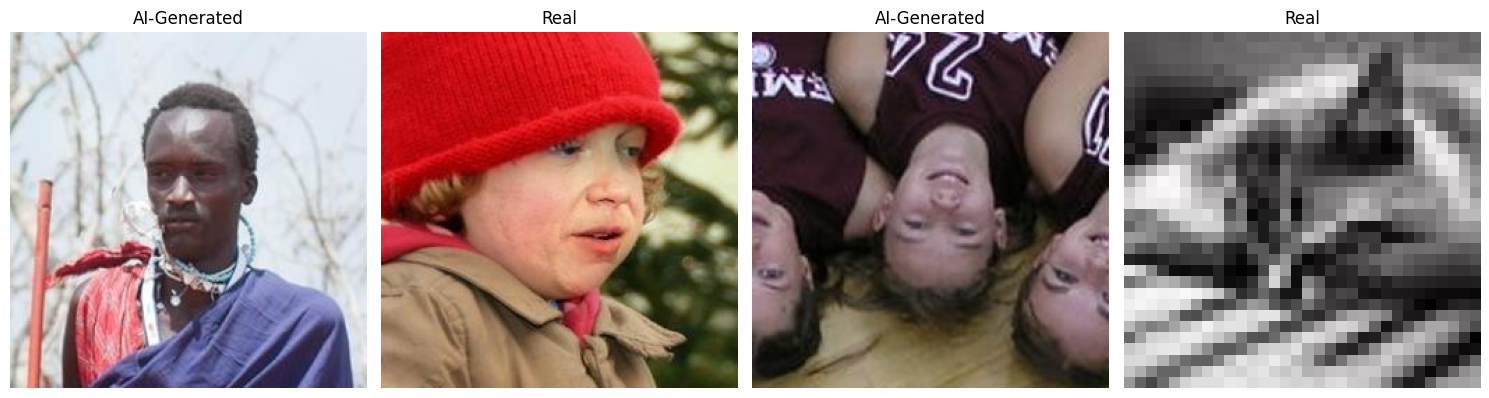

In [125]:
# Display a few sample images with their labels
def show_images(dataset, split='train', num_images=4):
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        idx = np.random.randint(0, len(dataset[split]))
        example = dataset[split][idx]
        image = example['image']
        label = "AI-Generated" if example['label'] == 1 else "Real"
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"{label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images from the training set
show_images(dataset, split='train', num_images=4)


Train split information:
Total examples: 152710
Results based on sample of 1000 examples:
Real images (label 0): 549 (54.90%)
AI-Generated images (label 1): 451 (45.10%)


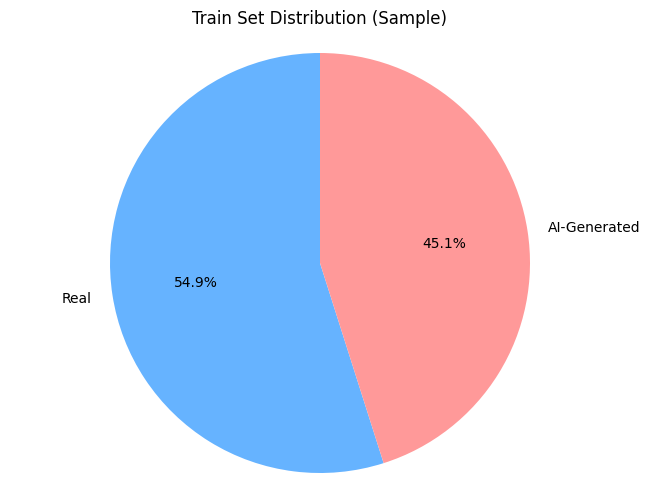

In [126]:
# Analyze the dataset distribution
def analyze_dataset_distribution(dataset):
        for split in dataset.keys():
                # Count labels directly using dataset features instead of iterating
                # This avoids potential issues with image decoding
                try:
                        # Get dataset info
                        print(f"\n{split.capitalize()} split information:")
                        print(f"Total examples: {len(dataset[split])}")
                        
                        # Sample a small subset to analyze labels
                        # This reduces the chance of running into corrupt images
                        sample_size = min(1000, len(dataset[split]))
                        indices = np.random.choice(len(dataset[split]), sample_size, replace=False)
                        
                        # Use .select to get a subset with specific indices
                        # This is more efficient than iterating through the entire dataset
                        subset = dataset[split].select(indices)
                        
                        # Extract labels from the subset
                        # Using this approach avoids processing all images
                        label_column = subset['label']
                        label_counts = {0: label_column.count(0), 1: label_column.count(1)}
                        total = len(label_column)
                        
                        print(f"Results based on sample of {sample_size} examples:")
                        print(f"Real images (label 0): {label_counts[0]} ({label_counts[0]/total*100:.2f}%)")
                        print(f"AI-Generated images (label 1): {label_counts[1]} ({label_counts[1]/total*100:.2f}%)")
                        
                        # Create a pie chart of the distribution
                        plt.figure(figsize=(8, 6))
                        plt.pie([label_counts[0], label_counts[1]], labels=['Real', 'AI-Generated'], 
                                autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
                        plt.title(f"{split.capitalize()} Set Distribution (Sample)")
                        plt.axis('equal')
                        plt.show()
                except Exception as e:
                        print(f"Error analyzing {split} split: {str(e)}")
                        print("Try using dataset features directly instead:")
                        features = dataset[split].features
                        print(f"Features: {features}")

# Analyze dataset distribution
analyze_dataset_distribution(dataset)

In [127]:
# Check image dimensions
def check_image_dimensions(dataset, split='train', num_samples=100):
    widths = []
    heights = []
    channels = []
    
    print(f"Checking image dimensions for {num_samples} samples from {split} set...")
    # Convert to native Python integers to avoid numpy.int64 TypeError
    sample_indices = np.random.choice(len(dataset[split]), min(num_samples, len(dataset[split])), replace=False).tolist()
    
    for i in sample_indices:
        try:
            # Convert numpy.int64 to Python int if needed
            if not isinstance(i, int):
                i = int(i)
                
            img = dataset[split][i]['image']
            if hasattr(img, 'size'):
                widths.append(img.size[0])
                heights.append(img.size[1])
                if isinstance(img, Image.Image):
                    if img.mode == 'RGB':
                        channels.append(3)
                    elif img.mode == 'L':
                        channels.append(1)
                    else:
                        channels.append(-1)  # Unknown
        except Exception as e:
            print(f"Error processing image at index {i}: {str(e)}")
            continue
    
    if widths and heights:
        print(f"\nImage dimensions summary:")
        print(f"Width range: {min(widths)} to {max(widths)} pixels")
        print(f"Height range: {min(heights)} to {max(heights)} pixels")
        
        if len(set(widths)) == 1 and len(set(heights)) == 1:
            print(f"All images are consistent size: {widths[0]}x{heights[0]} pixels")
        else:
            print("Images have varying dimensions")
            
        if channels:
            channel_count = {1: channels.count(1), 3: channels.count(3), -1: channels.count(-1)}
            print(f"\nChannel distribution:")
            for ch, count in channel_count.items():
                if count > 0:
                    if ch == 1:
                        print(f"Grayscale images (1 channel): {count}")
                    elif ch == 3:
                        print(f"RGB images (3 channels): {count}")
                    elif ch == -1:
                        print(f"Other format images: {count}")
    else:
        print("Could not process any images successfully. Check for errors above.")

# Check image dimensions
check_image_dimensions(dataset)

Checking image dimensions for 100 samples from train set...

Image dimensions summary:
Width range: 32 to 1600 pixels
Height range: 32 to 900 pixels
Images have varying dimensions

Channel distribution:
RGB images (3 channels): 100


## 3. Modified LeNet Architecture

Here, we implement our enhanced LeNet architecture with the following modifications:

1. Increased depth (8 convolutional layers)
2. Multiple filter sizes
3. Batch normalization
4. Dropout layers
5. Skip connections
6. Attention mechanism
7. Support for RGB inputs and larger image sizes

In [128]:
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        attention_map = self.sigmoid(self.conv(x))
        return x * attention_map

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ModifiedLeNet(nn.Module):
    def __init__(self, num_classes=2, input_channels=3, input_size=256):
        super(ModifiedLeNet, self).__init__()
        
        # Calculate the size after convolutions and pooling
        # Assuming input_size is a power of 2 and >= 128
        final_size = input_size // 32  # After 5 max-pooling operations with stride 2
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # First block with 64 filters
        self.block1 = ResidualBlock(64, 64)
        self.attention1 = AttentionModule(64)
        
        # Second block with 128 filters
        self.block2 = ResidualBlock(64, 128, stride=2)
        self.attention2 = AttentionModule(128)
        
        # Third block with 256 filters
        self.block3 = ResidualBlock(128, 256, stride=2)
        self.attention3 = AttentionModule(256)
        
        # Fourth block with 512 filters
        self.block4 = ResidualBlock(256, 512, stride=2)
        self.attention4 = AttentionModule(512)

        # Fully connected layers with dropout
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # Initial convolution
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        
        # Residual blocks with attention
        x = self.attention1(self.block1(x))
        x = self.attention2(self.block2(x))
        x = self.attention3(self.block3(x))
        x = self.attention4(self.block4(x))
        
        # Global average pooling and fully connected layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Create an instance of the model
model = ModifiedLeNet(num_classes=2, input_channels=3, input_size=256)
model = model.to(device)

# Display model architecture
print(model)

ModifiedLeNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (attention1): AttentionModule(
    (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (b

## 4. Data Loading and Preprocessing

Set up data preprocessing pipelines and loaders. This section should be modified to point to your specific dataset location.

In [129]:
# Data transformations
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the ELAImageDataset class
class ELAImageDataset(Dataset):
    def __init__(self, root_dir=None, transform=None, apply_ela=True, ela_quality=95, huggingface_dataset=None):
        self.transform = transform
        self.apply_ela = apply_ela
        self.ela_quality = ela_quality
        self.huggingface_dataset = huggingface_dataset
        
        if huggingface_dataset is not None:
            # We're using a HuggingFace dataset
            self.dataset = huggingface_dataset
            self.classes = ['real', 'ai-generated']  # 0 for real, 1 for AI-generated
        else:
            # We're using a local dataset
            self.dataset = ImageFolder(root_dir)
            self.classes = self.dataset.classes
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Default fallback label - we'll set this to a more appropriate value if possible
        fallback_label = 0
        
        try:
            if self.huggingface_dataset is not None:
                # HuggingFace dataset format
                sample = self.dataset[idx]
                image = sample['image']
                label = sample['label']
                # Update fallback label when we know the actual label
                fallback_label = label
            else:
                # Local dataset format
                image, label = self.dataset[idx]
                # Update fallback label when we know the actual label
                fallback_label = label
            
            # Ensure image is in RGB mode (handle RGBA or other formats)
            if isinstance(image, Image.Image):
                if image.mode == 'RGBA':
                    # Convert RGBA to RGB
                    image = image.convert('RGB')
                elif image.mode != 'RGB':
                    # Convert any other format to RGB
                    image = image.convert('RGB')
            
            # Apply ELA if requested
            if self.apply_ela:
                try:
                    image = error_level_analysis(image, quality=self.ela_quality)
                except Exception as e:
                    # Just print error and continue with original image
                    print(f"ELA processing error: {e} - Using original image")
            
            # Apply transformations
            if self.transform is not None:
                image = self.transform(image)
                
            return image, label
            
        except Exception as e:
            print(f"Error processing image at index {idx}: {str(e)}")
            # Create an emergency fallback - a black image with the same label if we know it
            if self.transform is not None:
                # Create a black RGB image
                fallback = Image.new('RGB', (256, 256), color=0)
                fallback_tensor = self.transform(fallback)
                return fallback_tensor, fallback_label
            else:
                fallback = Image.new('RGB', (256, 256), color=0)
                return fallback, fallback_label

# Set a more conservative batch size and fewer workers to reduce errors
BATCH_SIZE = 16  # Smaller batch size
NUM_WORKERS = 1  # Use just one worker to avoid multiprocessing issues

# Print available splits in the dataset
print(f"Available dataset splits: {list(dataset.keys())}")

# Check if we need to create a validation split from the training data
if 'validation' not in dataset:
    print("No validation split found. Creating validation set from train split...")
    # Calculate split sizes - use 80% for training, 20% for validation
    train_size = int(0.8 * len(dataset['train']))
    val_size = len(dataset['train']) - train_size
    
    # Split the training set
    train_val_dataset = dataset['train'].train_test_split(
        test_size=val_size, train_size=train_size, seed=42
    )
    
    # Create new datasets
    train_data = train_val_dataset['train']
    val_data = train_val_dataset['test']
    
    print(f"Split train dataset into {len(train_data)} training examples and {len(val_data)} validation examples")
else:
    # Use existing splits
    print("Using existing validation split")
    train_data = dataset['train']
    val_data = dataset['validation']

# Set up for training with the Hugging Face dataset
train_dataset = ELAImageDataset(
    huggingface_dataset=train_data, 
    transform=transform_train,
    apply_ela=True,
    ela_quality=95
)

val_dataset = ELAImageDataset(
    huggingface_dataset=val_data, 
    transform=transform_test,
    apply_ela=True,
    ela_quality=95
)

# Check if test split exists
if 'test' in dataset:
    test_dataset = ELAImageDataset(
        huggingface_dataset=dataset['test'], 
        transform=transform_test,
        apply_ela=True,
        ela_quality=95
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if torch.cuda.is_available() else False)
    print(f"Test samples: {len(test_dataset)}")
else:
    print("No test split found. Using validation set for testing.")
    test_dataset = val_dataset
    test_loader = None

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=False,  # Avoid persistent workers to prevent memory issues
    drop_last=True  # Drop the last incomplete batch to avoid size issues
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=False,  # Avoid persistent workers to prevent memory issues
    drop_last=False  # Keep all samples for validation
)

if test_loader is None and 'test' not in dataset:
    test_loader = val_loader

# Print dataset information
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")

Available dataset splits: ['train']
No validation split found. Creating validation set from train split...
Split train dataset into 122168 training examples and 30542 validation examples
No test split found. Using validation set for testing.
Training samples: 122168
Validation samples: 30542
Classes: ['real', 'ai-generated']


## 5. Training Functions

In [130]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss / (progress_bar.n + 1),
            'acc': 100. * correct / total
        })
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return train_loss, train_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss / (progress_bar.n + 1),
                'acc': 100. * correct / total
            })
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    # Calculate additional metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='binary')
    
    return val_loss, val_acc, precision, recall, f1, all_targets, all_preds

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, save_path="model_best.pth"):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train one epoch
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, precision, recall, f1, _, _ = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)
        
        # Print statistics
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            print(f"Validation accuracy improved from {best_val_acc:.2f}% to {val_acc:.2f}%. Saving model...")
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
    
    return model, history

## 6. Define Loss Function, Optimizer, and Learning Rate Scheduler

In [131]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/home/icarus/miniconda3/envs/school/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 7. Train the Model

Uncomment and run this section when your dataset is ready.

In [ ]:
# Define number of training epochs
num_epochs = 20

# Train the model
trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    save_path="modified_lenet_best.pth"
)


Epoch 1/20


Training:   0%|          | 0/7635 [00:00<?, ?it/s]

## 8. Visualize Training History

History contains 1 epochs of data
Training accuracy values: [65.73182711198429]
Validation accuracy values: [67.73295789404754]


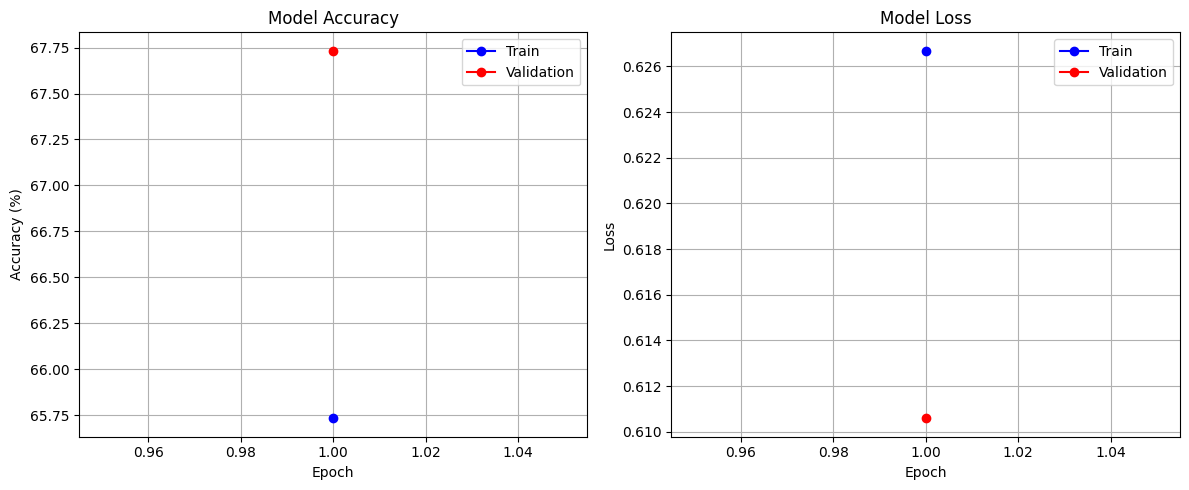

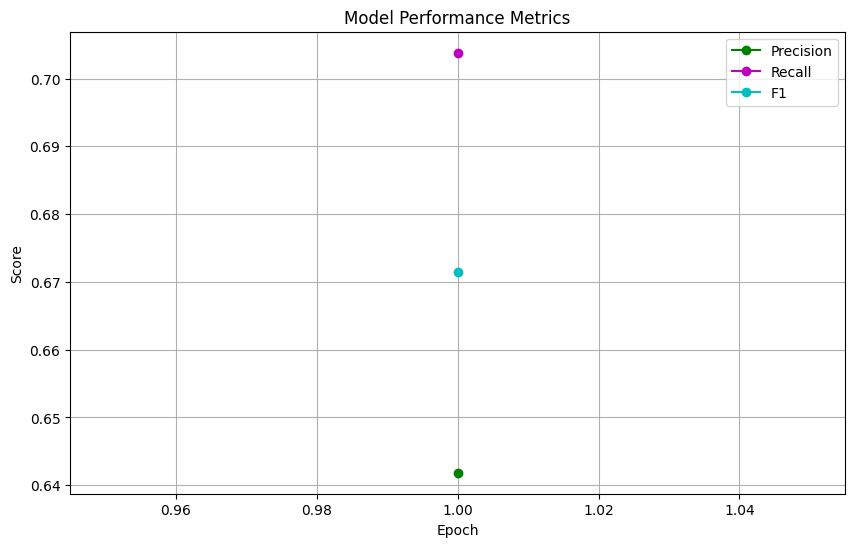

Final training metrics after 1 epochs:
Training accuracy: 65.73%
Validation accuracy: 67.73%
F1 Score: 0.6714
Precision: 0.6418
Recall: 0.7038


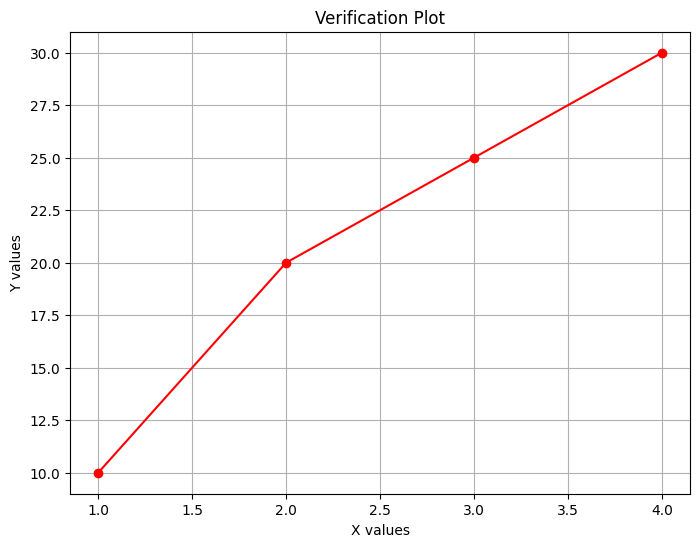


Raw history data for debugging:
Epoch 1: Train Acc=65.73%, Val Acc=67.73%, Train Loss=0.6267, Val Loss=0.6106, P=0.6418, R=0.7038, F1=0.6714


In [ ]:
# First, make sure we have history data to visualize
if 'history' in globals() and history:
    # Check if history contains data
    print(f"History contains {len(history['train_acc'])} epochs of data")
    
    # Convert data to lists if they aren't already
    epochs = list(range(1, len(history['train_acc']) + 1))
    train_acc = [float(x) for x in history['train_acc']]
    val_acc = [float(x) for x in history['val_acc']]
    train_loss = [float(x) for x in history['train_loss']]
    val_loss = [float(x) for x in history['val_loss']]
    precision = [float(x) for x in history['precision']]
    recall = [float(x) for x in history['recall']]
    f1 = [float(x) for x in history['f1']]
    
    print("Training accuracy values:", train_acc)
    print("Validation accuracy values:", val_acc)
    
    # Create a simple figure for accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'bo-')
    plt.plot(epochs, val_acc, 'ro-')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.grid(True)
    
    # Create a simple figure for loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'bo-')
    plt.plot(epochs, val_loss, 'ro-')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Create a simple figure for precision, recall, and F1
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, precision, 'go-', label='Precision')
    plt.plot(epochs, recall, 'mo-', label='Recall')
    plt.plot(epochs, f1, 'co-', label='F1')
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print the final metrics
    print(f"Final training metrics after {len(history['train_acc'])} epochs:")
    print(f"Training accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"Validation accuracy: {history['val_acc'][-1]:.2f}%")
    print(f"F1 Score: {history['f1'][-1]:.4f}")
    print(f"Precision: {history['precision'][-1]:.4f}")
    print(f"Recall: {history['recall'][-1]:.4f}")
else:
    print("No training history data available. Please train the model first.")
    print("Run the training cell to generate history data.")

# If you still don't see lines, try plotting with matplotlib directly
if 'history' in globals() and history:
    # Direct access to matplotlib for troubleshooting
    import matplotlib.pyplot as plt
    
    # Create a very simple plot to verify matplotlib is working
    plt.figure(figsize=(8, 6))
    plt.plot([1, 2, 3, 4], [10, 20, 25, 30], 'ro-')
    plt.title('Verification Plot')
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.grid(True)
    plt.show()
    
    # If you want to check the actual values being plotted
    print("\nRaw history data for debugging:")
    for i, (ta, va, tl, vl, p, r, f) in enumerate(zip(
            history['train_acc'], history['val_acc'], 
            history['train_loss'], history['val_loss'],
            history['precision'], history['recall'], history['f1']
        )):
        print(f"Epoch {i+1}: Train Acc={ta:.2f}%, Val Acc={va:.2f}%, Train Loss={tl:.4f}, Val Loss={vl:.4f}, P={p:.4f}, R={r:.4f}, F1={f:.4f}")

## 9. Evaluate Model on Test Set and Create Confusion Matrix

Evaluating model on test dataset...


Validation:   0%|          | 0/1909 [00:00<?, ?it/s]


Test Results:
Accuracy: 67.73%
Precision: 0.6418
Recall: 0.7038
F1 Score: 0.6714


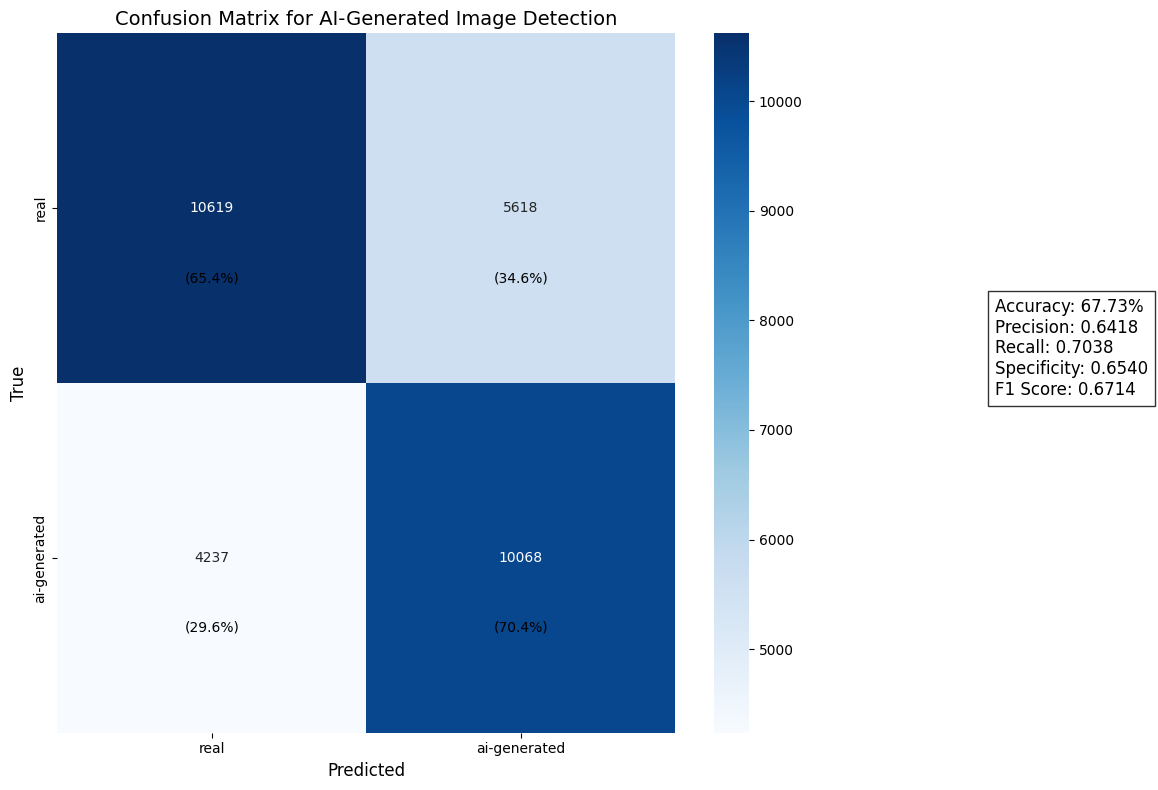


Metrics for class 'real':
Precision: 0.7148
Recall: 0.6540
F1 Score: 0.6830

Metrics for class 'ai-generated':
Precision: 0.6418
Recall: 0.7038
F1 Score: 0.6714


In [ ]:
# Evaluate model on test set and create confusion matrix
# Load the best model
model.load_state_dict(torch.load("modified_lenet_best.pth"))
model.eval()

# We already have test_loader and test_dataset defined earlier
# No need to recreate them unless you want to use a different test dataset
print("Evaluating model on test dataset...")

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall, test_f1, y_true, y_pred = validate(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"Accuracy: {test_acc:.2f}%")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a more visually appealing confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix for AI-Generated Image Detection', fontsize=14)

# Add text annotations with percentages
total = np.sum(cm)
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j + 0.5, i + 0.7, f'({cm[i][j]/np.sum(cm[i]):.1%})', 
                 ha='center', va='center', fontsize=10, color='black')

# Calculate and display metrics derived from confusion matrix
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

metrics_text = (f"Accuracy: {test_acc:.2f}%\n"
                f"Precision: {test_precision:.4f}\n"
                f"Recall: {test_recall:.4f}\n"
                f"Specificity: {specificity:.4f}\n"
                f"F1 Score: {test_f1:.4f}")

plt.figtext(1.0, 0.5, metrics_text, fontsize=12, ha="left", 
            bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# Print class-wise metrics
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(y_true, y_pred)
for i, class_name in enumerate(test_dataset.classes):
    print(f"\nMetrics for class '{class_name}':")
    print(f"Precision: {precision_per_class[i]:.4f}")
    print(f"Recall: {recall_per_class[i]:.4f}")
    print(f"F1 Score: {f1_per_class[i]:.4f}")

## 10. Visualize Feature Maps to Understand What the Model is Learning

Selected random image #5401 with true label: Real


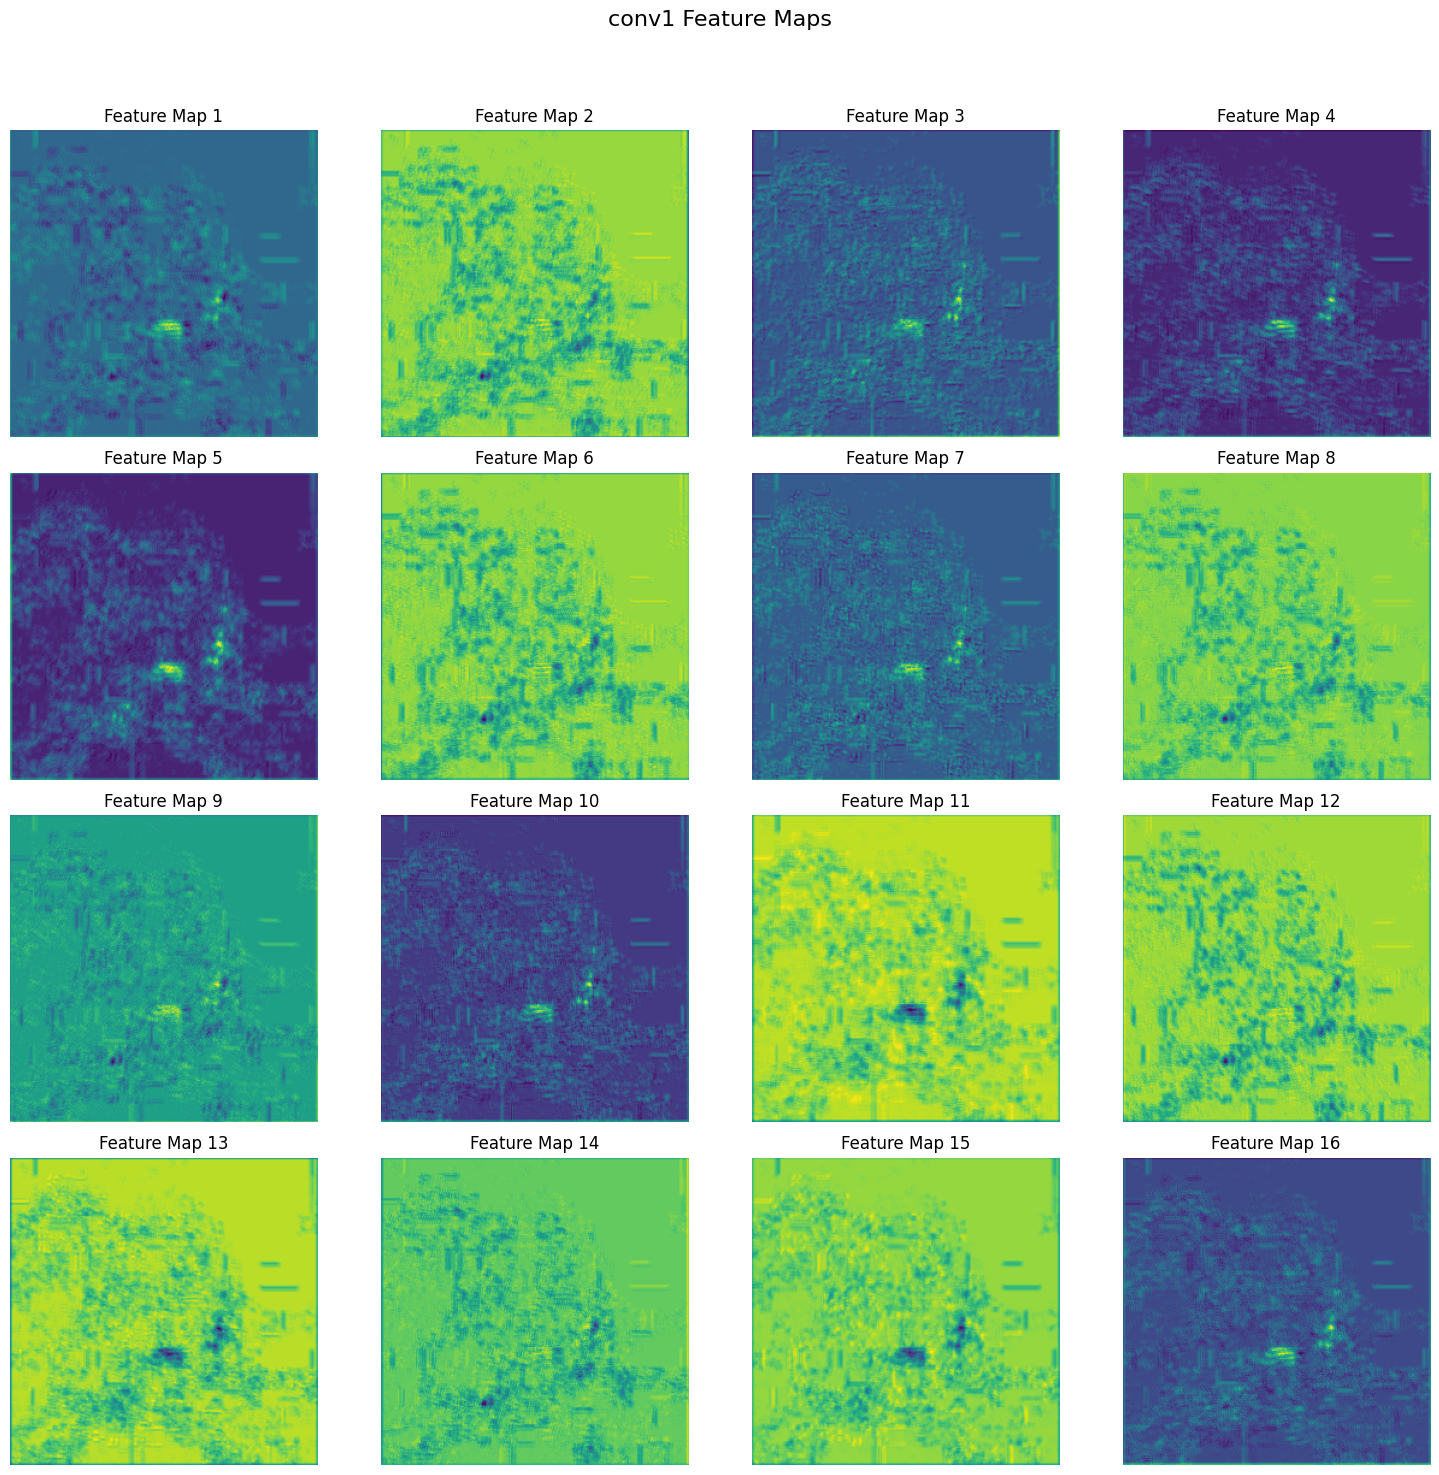

Model prediction: AI-Generated


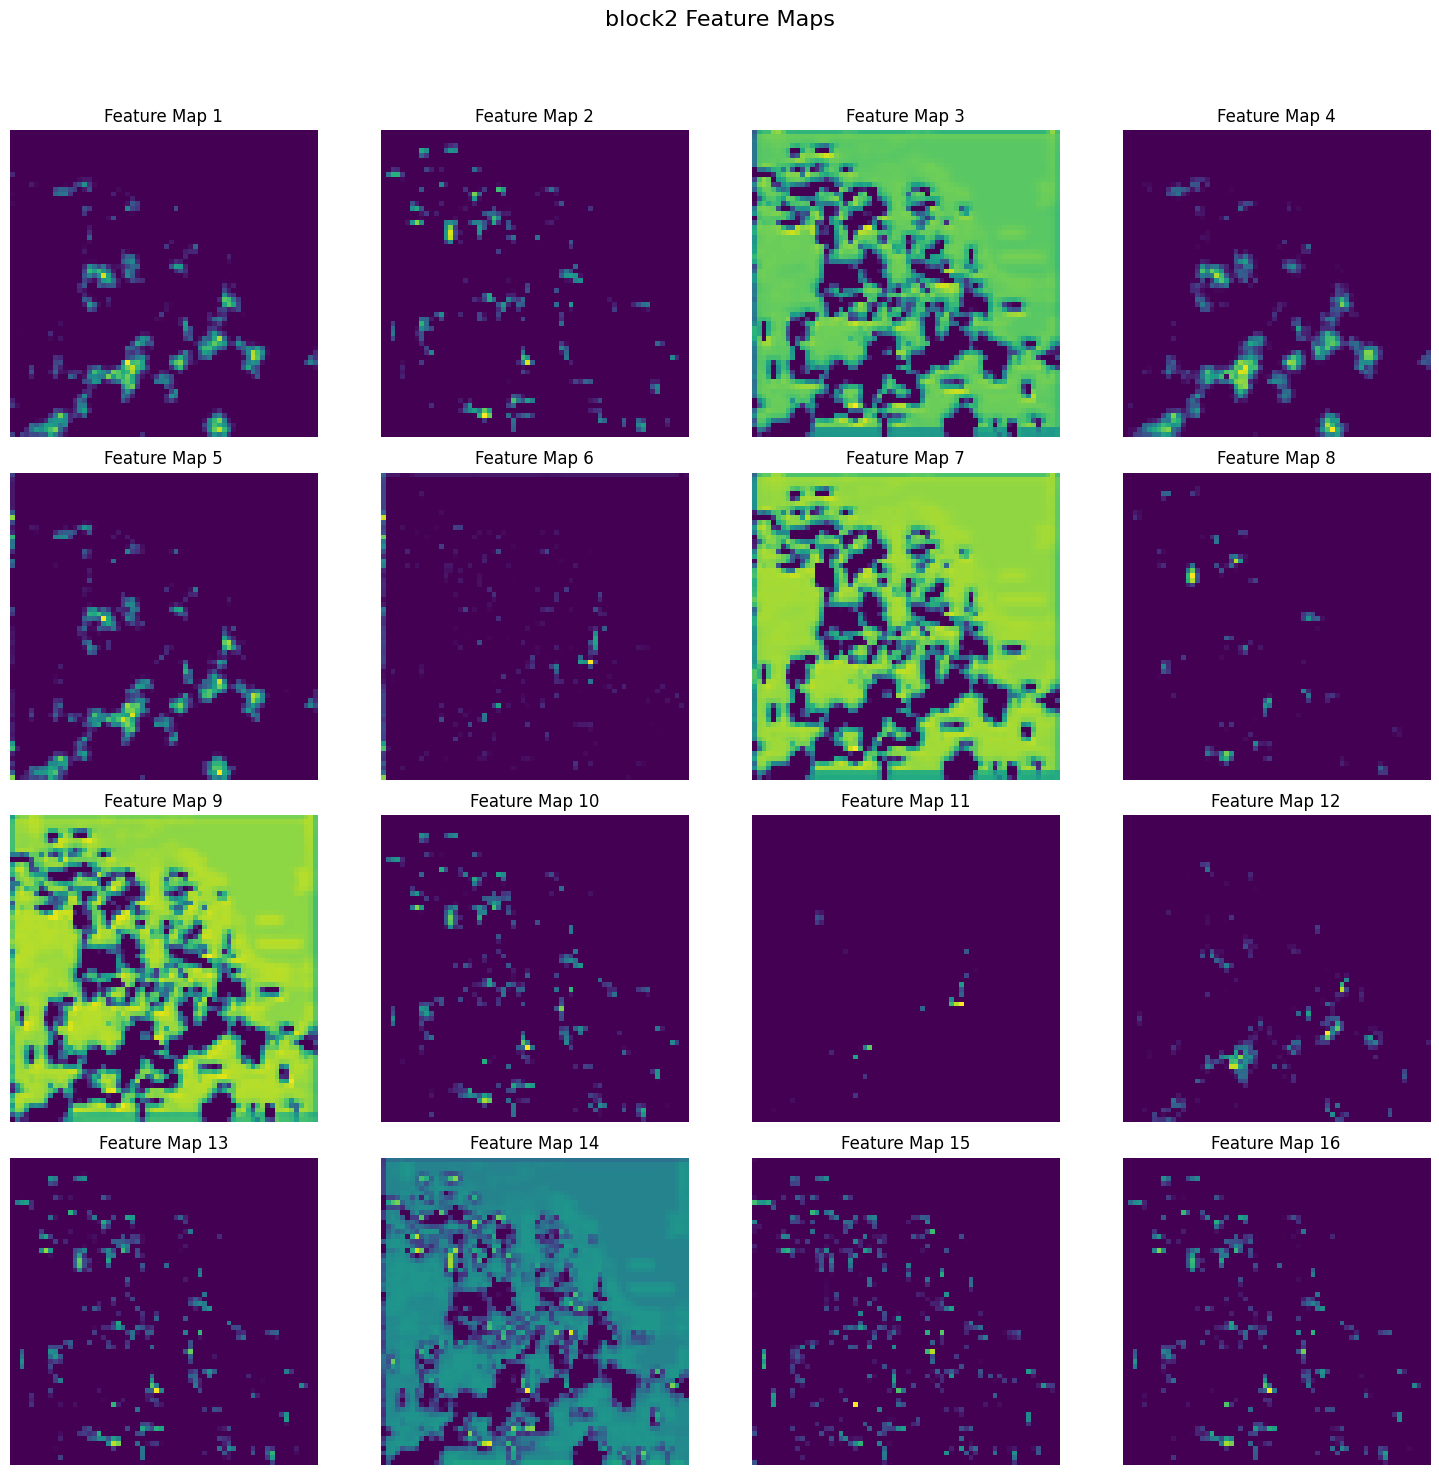

In [ ]:
# Function to visualize feature maps
def visualize_feature_maps(model, image_tensor=None, image_path=None, device=device, layer_name="conv1"):
    """
    Visualize feature maps from the model for a given image
    
    Args:
        model: The trained model
        image_tensor: Optional pre-loaded image tensor
        image_path: Optional path to an image file
        device: Device to run the model on
        layer_name: Name of the layer to visualize
    """
    # Create a hook to get feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    # Register hook
    if layer_name == "conv1":
        model.conv1.register_forward_hook(get_activation('conv1'))
    elif layer_name == "block1":
        model.block1.register_forward_hook(get_activation('block1'))
    elif layer_name == "block2":
        model.block2.register_forward_hook(get_activation('block2'))
    
    # Process the image
    if image_tensor is not None:
        # Use provided tensor
        input_tensor = image_tensor.unsqueeze(0).to(device) if image_tensor.dim() == 3 else image_tensor.to(device)
        original_image = None
    elif image_path is not None:
        # Load and preprocess image from path
        image = Image.open(image_path).convert('RGB')
        # Apply ELA
        ela_image = error_level_analysis(image)
        # Apply transformations
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = transform(ela_image).unsqueeze(0).to(device)
        original_image = image
        processed_image = ela_image
    else:
        raise ValueError("Either image_tensor or image_path must be provided")
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
    
    # Get feature maps
    feature_maps = activation[layer_name].squeeze().cpu()
    
    # Plot original and processed image if available
    if original_image is not None:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(processed_image)
        plt.title('ELA Processed Image')
        plt.axis('off')
        
        plt.suptitle(f"Prediction: {'AI-Generated' if pred == 1 else 'Real'}", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # Plot feature maps
    num_maps = min(16, feature_maps.size(0))  # Display up to 16 feature maps
    plt.figure(figsize=(15, 15))
    
    for i in range(num_maps):
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.title(f'Feature Map {i+1}')
        plt.axis('off')
        
    plt.suptitle(f"{layer_name} Feature Maps", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    return pred

# Example usage - uncomment to visualize feature maps
# Load model first
model.load_state_dict(torch.load("modified_lenet_best.pth"))
model.eval()

# Get a random image from the test dataset
def get_random_image_from_dataset(dataset):
    """Get a random image from the dataset"""
    idx = np.random.randint(0, len(dataset))
    image, label = dataset[idx]
    return image, label, idx

# Visualize feature maps using a random image from the dataset
image_tensor, true_label, img_idx = get_random_image_from_dataset(test_dataset)
print(f"Selected random image #{img_idx} with true label: {'AI-Generated' if true_label == 1 else 'Real'}")

# Visualize feature maps for this image
pred_label = visualize_feature_maps(model, image_tensor=image_tensor, layer_name="conv1")
print(f"Model prediction: {'AI-Generated' if pred_label == 1 else 'Real'}")

# Visualize deeper layers for the same image
_ = visualize_feature_maps(model, image_tensor=image_tensor, layer_name="block2")

## 11. Model Inference Function for New Images

We'll implement functions to allow file uploads to the notebook and use our model to predict if uploaded images are real or AI-generated.

In [ ]:
from IPython.display import display
import ipywidgets as widgets
import io

def predict_image(model, image_path=None, image_pil=None, device=device, apply_ela=True):
    """Make prediction on an image using the model
    
    Args:
        model: The trained model
        image_path: Path to the image file (optional)
        image_pil: PIL Image object (optional)
        device: Device to run inference on
        apply_ela: Whether to apply Error Level Analysis
        
    Returns:
        tuple: (prediction, confidence)
    """
    # Load image from path or use provided PIL image
    if image_pil is not None:
        image = image_pil
    elif image_path is not None:
        image = Image.open(image_path).convert('RGB')
    else:
        raise ValueError("Either image_path or image_pil must be provided")
    
    # Store original image for display
    original_image = image.copy()
    
    # Apply ELA if requested
    if apply_ela:
        ela_image = error_level_analysis(image)
    else:
        ela_image = image
    
    # Apply transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(ela_image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Get prediction and confidence
    prediction = "AI-Generated" if predicted.item() == 1 else "Real"
    confidence = probabilities[0][predicted.item()].item() * 100
    
    # Display results with both original and ELA images
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(ela_image)
    plt.title('ELA Processed Image')
    plt.axis('off')
    
    plt.suptitle(f"Prediction: {prediction} (Confidence: {confidence:.2f}%)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return prediction, confidence, probabilities[0].cpu().numpy()

# File upload widget for images
def create_upload_widget():
    upload_widget = widgets.FileUpload(
        accept='.jpg,.jpeg,.png',
        multiple=False,
        description='Upload Image:',
        style={'description_width': 'initial'},
        button_style='info'
    )
    return upload_widget

def on_upload_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        # Get the uploaded file - handle both dictionary and tuple formats
        if not change['new']:
            # Empty upload
            return
            
        try:
            # First try to handle it as a dictionary
            if isinstance(change['new'], dict):
                uploaded_file = list(change['new'].values())[0]
            else:
                # If it's not a dict, it might be a tuple/list format
                uploaded_file = change['new'][0]
                
            # Convert to PIL Image
            image_data = uploaded_file['content']
            image_pil = Image.open(io.BytesIO(image_data)).convert('RGB')
            
            # Display progress message
            print("Image uploaded! Processing...")
            
            # Make prediction
            prediction, confidence, class_probs = predict_image(model, image_pil=image_pil)
            
            # Print detailed results
            print(f"Prediction: {prediction} with {confidence:.2f}% confidence")
            print(f"Class probabilities: Real: {class_probs[0]*100:.2f}%, AI-Generated: {class_probs[1]*100:.2f}%")
            
        except Exception as e:
            print(f"Error processing image: {str(e)}")
            print("Please try uploading a different image.")
            
        # Reset widget to allow another upload
        change['owner'].value = {}

# Create interactive widget for image upload and prediction
def setup_interactive_prediction():
    # Make sure the model is loaded
    try:
        model.load_state_dict(torch.load("modified_lenet_best.pth"))
        model.eval()
        print("Model loaded successfully from 'modified_lenet_best.pth'")
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        print("Using current model state instead")
    
    # Create upload widget
    upload_widget = create_upload_widget()
    
    # Register callback
    upload_widget.observe(on_upload_change, names='value')
    
    # Display instructions and widget
    print("Upload an image to detect if it's real or AI-generated.")
    print("The model will process the image and show the prediction results.")
    display(upload_widget)
    
    return upload_widget

Model loaded successfully from 'modified_lenet_best.pth'
Upload an image to detect if it's real or AI-generated.
The model will process the image and show the prediction results.


FileUpload(value=(), accept='.jpg,.jpeg,.png', button_style='info', description='Upload Image:')

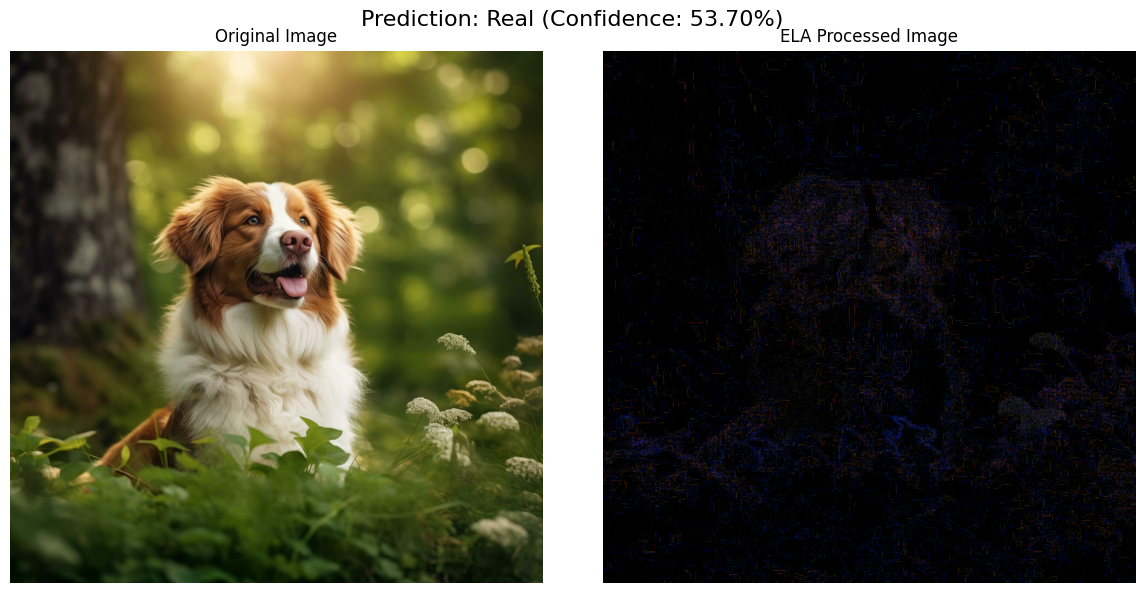

TraitError: The 'value' trait of a FileUpload instance expected a tuple, not the dict {}.

In [ ]:
# Setup and display the interactive prediction widget
upload_widget = setup_interactive_prediction()

### Batch Processing Multiple Images

You can also upload and process multiple images at once using the widget below.

In [ ]:
def create_batch_upload_widget():
    upload_widget = widgets.FileUpload(
        accept='.jpg,.jpeg,.png',
        multiple=True,
        description='Upload Multiple Images:',
        style={'description_width': 'initial'},
        button_style='info'
    )
    return upload_widget

def on_batch_upload_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        # Get all uploaded files
        uploaded_files = list(change['new'].values())
        
        if not uploaded_files:
            return
            
        print(f"Processing {len(uploaded_files)} images...")
        
        # Create results table
        results = []
        
        # Process each image
        for i, uploaded_file in enumerate(uploaded_files):
            # Convert to PIL Image
            image_data = uploaded_file['content']
            image_pil = Image.open(io.BytesIO(image_data)).convert('RGB')
            filename = uploaded_file['name']
            
            # Make prediction
            prediction, confidence, class_probs = predict_image(model, image_pil=image_pil)
            
            # Store results
            results.append({
                'Filename': filename,
                'Prediction': prediction,
                'Confidence': f"{confidence:.2f}%",
                'Real Prob': f"{class_probs[0]*100:.2f}%",
                'AI-Gen Prob': f"{class_probs[1]*100:.2f}%"
            })
        
        # Display results table
        df_results = pd.DataFrame(results)
        display(df_results)
        
        # Create summary statistics
        real_count = sum(1 for r in results if r['Prediction'] == 'Real')
        ai_count = sum(1 for r in results if r['Prediction'] == 'AI-Generated')
        
        print(f"\nSummary: {real_count} Real images, {ai_count} AI-Generated images")
        
        # Plot distribution
        plt.figure(figsize=(8, 5))
        plt.bar(['Real', 'AI-Generated'], [real_count, ai_count], color=['#66b3ff', '#ff9999'])
        plt.title('Prediction Distribution')
        plt.ylabel('Count')
        plt.grid(axis='y', alpha=0.3)
        plt.show()
        
        # Reset widget to allow another upload
        change['owner'].value = {}

# Create and display batch upload widget
batch_upload_widget = create_batch_upload_widget()
batch_upload_widget.observe(on_batch_upload_change, names='value')

print("Upload multiple images to process them as a batch.")
print("The results will be displayed in a table.")
display(batch_upload_widget)

Upload multiple images to process them as a batch.
The results will be displayed in a table.


FileUpload(value=(), accept='.jpg,.jpeg,.png', button_style='info', description='Upload Multiple Images:', mul…

AttributeError: 'tuple' object has no attribute 'values'

### Test with Random Images from Dataset

You can also test the model on random images from the test dataset.

In [ ]:
def test_on_random_images(num_images=5):
    """Test the model on random images from the test dataset"""
    # Make sure model is in evaluation mode
    model.eval()
    
    # Results storage
    results = []
    
    # Process multiple random images
    for i in range(num_images):
        # Get random image
        image_tensor, true_label, img_idx = get_random_image_from_dataset(test_dataset)
        true_class = "AI-Generated" if true_label == 1 else "Real"
        
        # Convert tensor to PIL Image for visualization
        # Denormalize the image
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        denorm_image = image_tensor.clone()
        for t, m, s in zip(denorm_image, mean, std):
            t.mul_(s).add_(m)
        denorm_image = denorm_image.clamp(0, 1)
        
        # Convert to PIL image
        img_pil = transforms.ToPILImage()(denorm_image)
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            input_tensor = image_tensor.unsqueeze(0).to(device)
            outputs = model(input_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
        # Get prediction and confidence
        prediction = "AI-Generated" if predicted.item() == 1 else "Real"
        confidence = probabilities[0][predicted.item()].item() * 100
        class_probs = probabilities[0].cpu().numpy()
        
        # Display results
        plt.figure(figsize=(8, 6))
        plt.imshow(img_pil)
        plt.title(f"True: {true_class} | Prediction: {prediction} (Conf: {confidence:.2f}%)")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Store results
        results.append({
            'Image Index': img_idx,
            'True Label': true_class,
            'Prediction': prediction,
            'Confidence': f"{confidence:.2f}%",
            'Correct': prediction == true_class
        })
    
    # Display results table
    df_results = pd.DataFrame(results)
    display(df_results)
    
    # Calculate accuracy
    accuracy = df_results['Correct'].mean() * 100
    print(f"\nAccuracy on random sample: {accuracy:.2f}%")
    
    return df_results

# Create a widget to set the number of random images to test
num_images_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=20,
    step=1,
    description='Number of images:',
    continuous_update=False,
    style={'description_width': 'initial'}
)

test_button = widgets.Button(
    description='Test Random Images',
    button_style='success',
    tooltip='Click to test on random images'
)

output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        test_on_random_images(num_images_slider.value)

test_button.on_click(on_button_clicked)

# Display the widgets
print("Test the model on random images from the test dataset:")
display(widgets.HBox([num_images_slider, test_button]))
display(output)

Test the model on random images from the test dataset:


Output()

## 12. Experiment with Multiple Detection Strategies

To improve robustness, we can implement an ensemble approach that combines multiple detection strategies.

In [ ]:
def ensemble_prediction(image_path, device, models_dict):
    """Make predictions using multiple models and strategies
    
    Args:
        image_path: Path to the image
        device: Torch device
        models_dict: Dictionary of {model_name: model}
    """
    results = {}
    final_votes = {"Real": 0, "AI-Generated": 0}
    
    # Original image detection
    original_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Process with ELA
    ela_image = error_level_analysis(image)
    
    # Make predictions with different models
    for model_name, model in models_dict.items():
        model.eval()
        with torch.no_grad():
            # Prepare input based on model requirements
            if "ela" in model_name.lower():
                input_tensor = original_transform(ela_image).unsqueeze(0).to(device)
            else:
                input_tensor = original_transform(image).unsqueeze(0).to(device)
                
            # Get prediction
            outputs = model(input_tensor)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            # Store results
            prediction = "AI-Generated" if predicted.item() == 1 else "Real"
            confidence = probs[0][predicted.item()].item() * 100
            results[model_name] = (prediction, confidence)
            
            # Add vote
            final_votes[prediction] += 1
    
    # Determine final prediction based on voting
    final_prediction = "AI-Generated" if final_votes["AI-Generated"] > final_votes["Real"] else "Real"
    
    # Display results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(ela_image)
    plt.title('ELA Processed Image')
    plt.axis('off')
    
    plt.suptitle(f"Final Prediction: {final_prediction}", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("Model Predictions:")
    for model_name, (pred, conf) in results.items():
        print(f"{model_name}: {pred} (Confidence: {conf:.2f}%)")
    
    print(f"\nFinal Prediction (Voting): {final_prediction} ({final_votes[final_prediction]}/{sum(final_votes.values())} votes)")
    
    return results, final_prediction

'''
# Load different models for ensemble prediction
model1 = ModifiedLeNet()
model1.load_state_dict(torch.load("model1_best.pth"))
model1 = model1.to(device)

model2 = ModifiedLeNet()  # You could use different architectures too
model2.load_state_dict(torch.load("model2_best.pth"))
model2 = model2.to(device)

# Create ensemble
models = {
    "Model1_ELA": model1,
    "Model2_RGB": model2
}

# Make ensemble prediction
image_path = "/path/to/test/image.jpg"  # Replace with actual path
results, final_prediction = ensemble_prediction(image_path, device, models)
'''

'\n# Load different models for ensemble prediction\nmodel1 = ModifiedLeNet()\nmodel1.load_state_dict(torch.load("model1_best.pth"))\nmodel1 = model1.to(device)\n\nmodel2 = ModifiedLeNet()  # You could use different architectures too\nmodel2.load_state_dict(torch.load("model2_best.pth"))\nmodel2 = model2.to(device)\n\n# Create ensemble\nmodels = {\n    "Model1_ELA": model1,\n    "Model2_RGB": model2\n}\n\n# Make ensemble prediction\nimage_path = "/path/to/test/image.jpg"  # Replace with actual path\nresults, final_prediction = ensemble_prediction(image_path, device, models)\n'

## 13. Conclusion

In this notebook, we've implemented a modified LeNet architecture specifically for AI-generated image detection. The key modifications include:

1. Increased network depth (8 convolutional layers vs. the original 2)
2. Added residual connections for better gradient flow
3. Incorporated attention mechanisms to focus on suspicious regions
4. Utilized Error Level Analysis (ELA) as an additional preprocessing step
5. Implemented dropout and batch normalization for better regularization
6. Expanded input size to 256×256 RGB (vs. original 32×32 grayscale)
7. Modified the output for binary classification (real vs. AI-generated)

This architecture should provide a strong baseline for detecting AI-generated images. For best results, the model should be trained on a diverse dataset containing various types of AI-generated content across multiple GAN architectures.